#### Post-campaign Model Development.

#### Load labraries

In [11]:
import pandas as pd
import joblib
from collections import Counter
import numpy as np
import random
import warnings
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

#### Dataset Split

Codes below load the preprocessed post_campaign dataset, split it into 70%, 15% and 15% for training, validation and test respectively and save it for reuse.

In [5]:
# 1. Load dataset

df = pd.read_csv(r"C:\Users\USER\Documents\Customer Intention\df_post_camp.csv")
target_col = 'y'
X = df.drop(columns=[target_col])
y = df[target_col]

# 2. Train / Val / Test split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 3. Compute class distribution

counter = Counter(y_train)
print("Training set class distribution:", counter)

# 4. Save the splits for reuse

joblib.dump((X_train, X_val, X_test, y_train, y_val, y_test),
            r"C:\Users\USER\Documents\Customer Intention\data_splits_post_camp.pkl")
print("✅ Data splits saved successfully")

Shapes -> Train: (28000, 42), Val: (6000, 42), Test: (6000, 42)
Training set class distribution: Counter({0: 25973, 1: 2027})
✅ Data splits saved successfully


#### Hyperparameter tuning

Codes below load the saved data split, validate LightGBM Model, tune its hyperparameters using 5-fold cv within hyperopt, use a custom scoring metric precision (40%) and recall (60%), test 30 hyperparameter configurations, experiment with class weights(7, 8, 9, 10, 12.8 and 15), auto genrate 3 random state seeds and experiment with them. Then print best class weight, seed and parameters. 

In [1]:
# Load saved data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_post_camp.pkl"
)
# Suppress all Python warnings
warnings.filterwarnings('ignore')


# 3. Hyperopt search space for LightGBM

search_space = {
    'num_leaves': hp.choice('num_leaves', np.arange(20, 150, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_samples': hp.uniform('min_child_samples', 5, 50),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500])
}

# 4. Seeds & Weights

NUM_SEEDS = 3
seeds = [random.randint(1000, 9999) for _ in range(NUM_SEEDS)]
manual_weights = [7, 8, 9, 10, 12.8, 15]

print(f"Generated seeds: {seeds}")

TRIALS_PER_COMBINATION = 30
CV_FOLDS = 5

# 5. Weighted precision-recall tradeoff

PRECISION_WEIGHT = 0.4  # 40% precision
RECALL_WEIGHT = 0.6      # 60% recall

results = []
start_all = time.time()

# 6. Main Tuning Loop

for seed in seeds:
    for weight in manual_weights:
        print(f"\n--- TUNING: seed={seed} | scale_pos_weight={weight} | trials={TRIALS_PER_COMBINATION} ---")
        start = time.time()

        def objective(params):
            # Cast integer parameters properly
            params['min_child_samples'] = int(params['min_child_samples'])
            params['num_leaves'] = int(params['num_leaves'])
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])

            clf = lgb.LGBMClassifier(
                objective='binary',
                random_state=seed,
                scale_pos_weight=weight,
                n_jobs=-1,
                verbosity=-1,  # suppress LightGBM training warnings
                **params
            )

            skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=seed)
            y_pred = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')

            precision = precision_score(y_train, y_pred, zero_division=0)
            recall = recall_score(y_train, y_pred, zero_division=0)
            combined_score = PRECISION_WEIGHT * precision + RECALL_WEIGHT * recall

            return {
                'loss': -combined_score,
                'status': STATUS_OK,
                'precision': precision,
                'recall': recall
            }

        trials = Trials()
        best = fmin(
            fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=TRIALS_PER_COMBINATION,
            trials=trials,
            rstate=np.random.default_rng(seed)
        )

        best_params = space_eval(search_space, best)
        best_trial = min(trials.trials, key=lambda x: x['result']['loss'])
        best_prec = best_trial['result']['precision']
        best_rec = best_trial['result']['recall']
        best_combined = PRECISION_WEIGHT * best_prec + RECALL_WEIGHT * best_rec

        results.append((seed, weight, best_prec, best_rec, best_combined, best_params))
        end = time.time()

        print(f"Done seed={seed} weight={weight} | "
              f"Precision={best_prec:.4f} | Recall={best_rec:.4f} | Combined={best_combined:.4f} | "
              f"time={end-start:.1f}s | best params={best_params}")

end_all = time.time()
elapsed_min = (end_all - start_all)/60
print(f"\nAll tuning complete in {elapsed_min:.2f} minutes")

# 7. Summary of all combinations

print("\nSummary of all combinations:")
for (seed, weight, precision, recall, combined, params) in results:
    print(f"Seed={seed} | Weight={weight} | Precision={precision:.4f} | Recall={recall:.4f} | Combined={combined:.4f}")


# 8. Print overall best combo

best_overall = max(results, key=lambda x: x[4])  # based on combined score
print("\n= BEST OVERALL COMBINATION (40% Precision, 60% Recall) =")
print(f"Seed={best_overall[0]} | Weight={best_overall[1]} | "
      f"Precision={best_overall[2]:.4f} | Recall={best_overall[3]:.4f} | "
      f"Combined={best_overall[4]:.4f}")
print(f"Best Params: {best_overall[5]}")

Shapes -> Train: (28000, 42), Val: (6000, 42), Test: (6000, 42)
Generated seeds: [2993, 7068, 9080]

--- TUNING: seed=2993 | scale_pos_weight=7 | trials=30 ---
100%|███████████████████████████████████████████████| 30/30 [01:30<00:00,  3.02s/trial, best loss: -0.6707367686384654]
Done seed=2993 weight=7 | Precision=0.4003 | Recall=0.8510 | Combined=0.6707 | time=90.8s | best params={'colsample_bytree': 0.8832734319330615, 'learning_rate': 0.02585952085497814, 'max_depth': np.int64(5), 'min_child_samples': 21.118774001158815, 'n_estimators': 300, 'num_leaves': np.int64(65), 'reg_alpha': 0.5875029450175789, 'reg_lambda': 0.317421203127716, 'subsample': 0.9526004046808403}

--- TUNING: seed=2993 | scale_pos_weight=8 | trials=30 ---
100%|███████████████████████████████████████████████| 30/30 [01:41<00:00,  3.39s/trial, best loss: -0.6757033807985464]
Done seed=2993 weight=8 | Precision=0.3891 | Recall=0.8668 | Combined=0.6757 | time=101.9s | best params={'colsample_bytree': 0.67770848145426

#### Train LGBM

Codes below load the saved data split and  train LGBM model with the best params using the selected seed and the class weight.

In [7]:
# Load saved data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_post_camp.pkl"
)

# 3. Best parameters (Precision 40%, Recall 60%)

best_params = {
    'colsample_bytree': 0.9898484895516747,
    'learning_rate': 0.17535635130256746,
    'max_depth': int(3),
    'min_child_samples': int(35.456569589811934),
    'n_estimators': int(200),
    'num_leaves': int(79),
    'reg_alpha': 0.7026875551698822,
    'reg_lambda': 0.5627960451289608,
    'subsample': 0.659158288588536
}

scale_pos_weight = 15
seed = 7068

# 4. Train final LightGBM model

final_model = lgb.LGBMClassifier(
    objective='binary',
    random_state=seed,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    verbosity=-1,  # suppress LightGBM warnings
    **best_params
)

final_model.fit(X_train, y_train)
print("model trained successfully")


model trained successfully


#### Evaluate the trained LGBM model

Codes below load the saved data split and evaluate the trained model using classification report, AUC, plot and print its confusion matrices.


=== Train ===
Precision: 0.3613, Recall: 0.9600, AUC: 0.9631
              precision    recall  f1-score   support

           0     0.9964    0.8676    0.9275     25973
           1     0.3613    0.9600    0.5250      2027

    accuracy                         0.8742     28000
   macro avg     0.6789    0.9138    0.7263     28000
weighted avg     0.9504    0.8742    0.8984     28000


=== Validation ===
Precision: 0.3470, Recall: 0.9149, AUC: 0.9473
              precision    recall  f1-score   support

           0     0.9924    0.8654    0.9246      5565
           1     0.3470    0.9149    0.5032       435

    accuracy                         0.8690      6000
   macro avg     0.6697    0.8902    0.7139      6000
weighted avg     0.9456    0.8690    0.8940      6000


=== Test ===
Precision: 0.3387, Recall: 0.9194, AUC: 0.9474
              precision    recall  f1-score   support

           0     0.9927    0.8600    0.9216      5566
           1     0.3387    0.9194    0.4950    

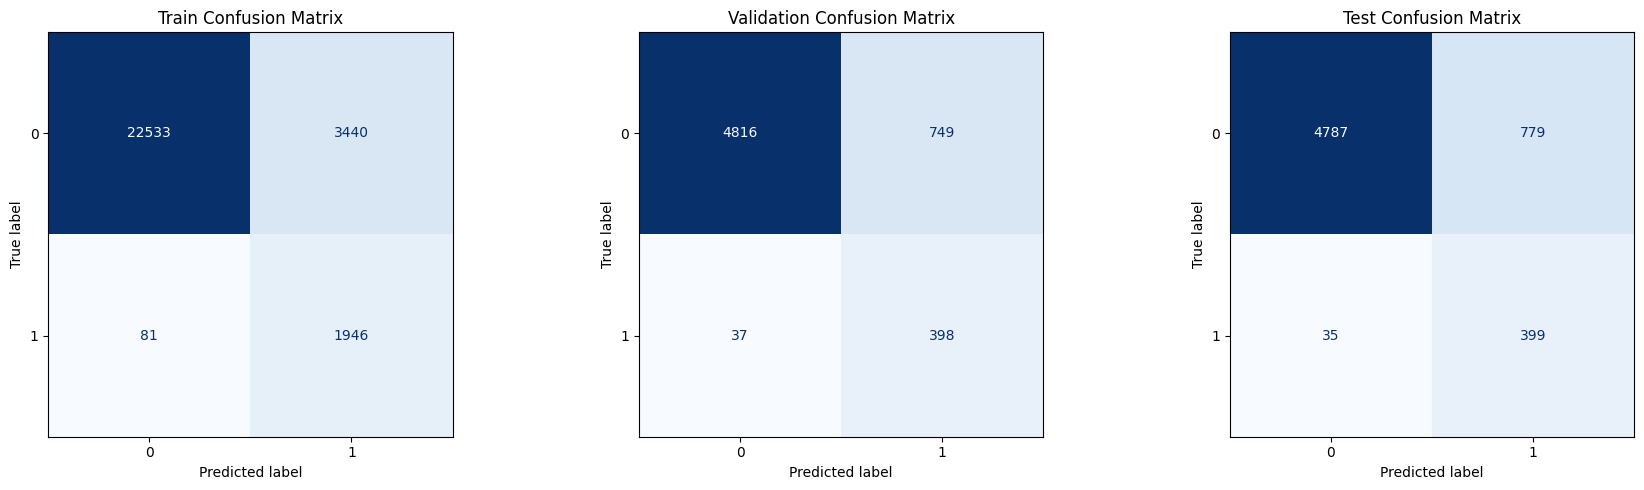

In [13]:
# Load saved data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_post_camp.pkl"
)

# 5. Evaluate model

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # for AUC

    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    auc = roc_auc_score(y, y_prob)
    report = classification_report(y, y_pred, digits=4, zero_division=0)
    cm = confusion_matrix(y, y_pred)

    return prec, rec, auc, report, cm


sets = [('Train', X_train, y_train),
        ('Validation', X_val, y_val),
        ('Test', X_test, y_test)]

metrics = []
for name, X_set, y_set in sets:
    prec, rec, auc, report, cm = evaluate_model(final_model, X_set, y_set)
    metrics.append((name, prec, rec, auc, report, cm))
    print(f"\n=== {name} ===")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, AUC: {auc:.4f}")
    print(report)

# 6. Plot confusion matrices

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, _, _, _, _, cm) in zip(axes, metrics):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()

#### Apply custom  Decision Threshold

Codes below load the saved data split and apply custom decision threshold on the trained LGBM to increase precision(efficiency of the model)


=== Train Set ===
Custom Threshold: 0.806
Precision: 0.5060 | Recall: 0.7879 | AUC: 0.9631
              precision    recall  f1-score   support

           0     0.9827    0.9400    0.9609     25973
           1     0.5060    0.7879    0.6162      2027

    accuracy                         0.9290     28000
   macro avg     0.7444    0.8639    0.7886     28000
weighted avg     0.9482    0.9290    0.9359     28000


=== Validation Set ===
Custom Threshold: 0.806
Precision: 0.4916 | Recall: 0.7356 | AUC: 0.9473
              precision    recall  f1-score   support

           0     0.9785    0.9405    0.9591      5565
           1     0.4916    0.7356    0.5893       435

    accuracy                         0.9257      6000
   macro avg     0.7350    0.8381    0.7742      6000
weighted avg     0.9432    0.9257    0.9323      6000


=== Test Set ===
Custom Threshold: 0.806
Precision: 0.4749 | Recall: 0.7396 | AUC: 0.9474
              precision    recall  f1-score   support

           

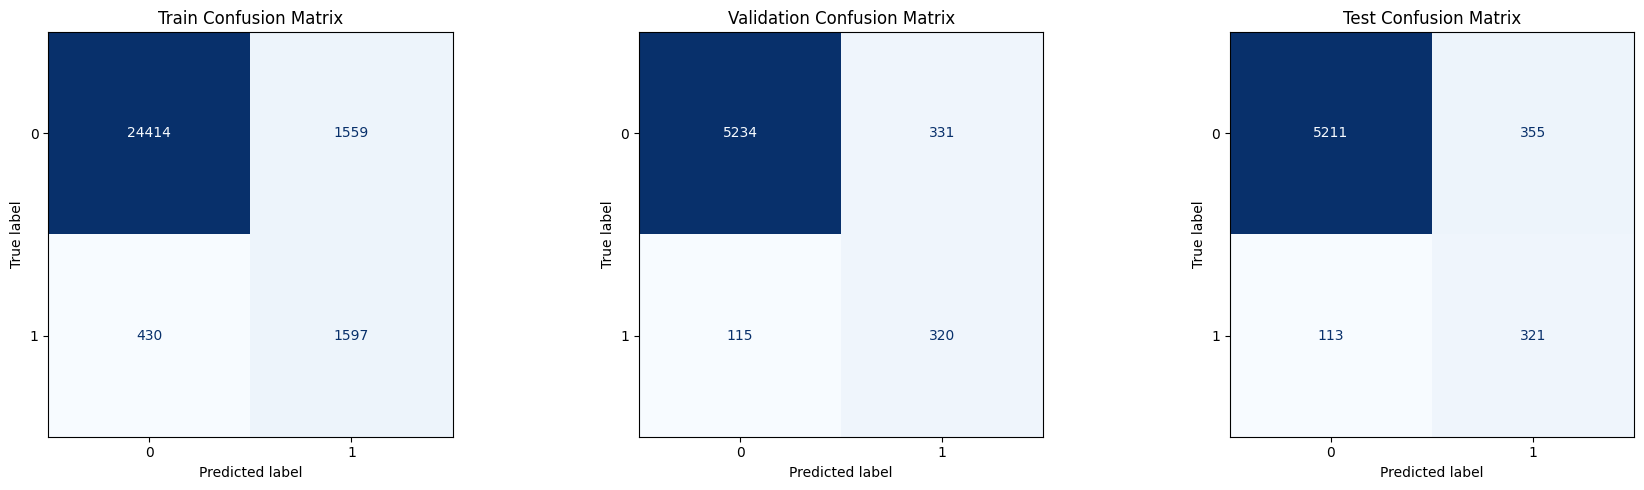

In [15]:
# 1. Load saved data splits

X_train, X_val, X_test, y_train, y_val, y_test = joblib.load(
    r"C:\Users\USER\Documents\Customer Intention\data_splits_post_camp.pkl"
)

# 1. Custom decision threshold

custom_threshold = 0.806

# 2. Evaluation function with custom threshold

def evaluate_model_custom_threshold(model, X, y, threshold):
    """Evaluate model using a custom probability threshold."""
    y_prob = model.predict_proba(X)[:, 1]  # probability for class 1
    y_pred = (y_prob >= threshold).astype(int)

    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    auc = roc_auc_score(y, y_prob)
    report = classification_report(y, y_pred, digits=4, zero_division=0)
    cm = confusion_matrix(y, y_pred)

    return prec, rec, auc, report, cm


# 3. Evaluate on Train, Val, Test sets

sets = [
    ('Train', X_train, y_train),
    ('Validation', X_val, y_val),
    ('Test', X_test, y_test)
]

metrics = []
for name, X_set, y_set in sets:
    prec, rec, auc, report, cm = evaluate_model_custom_threshold(final_model, X_set, y_set, custom_threshold)
    metrics.append((name, prec, rec, auc, report, cm))
    print(f"\n=== {name} Set ===")
    print(f"Custom Threshold: {custom_threshold}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | AUC: {auc:.4f}")
    print(report)

# 4. Plot confusion matrices

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, _, _, _, _, cm) in zip(axes, metrics):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()

From the test result above, the precision value has increased from 0.3387 to 0.4749

#### Save the trained model with the custom threshould.

In [17]:
model_package = {
    "model": final_model,
    "threshold": 0.806
}
joblib.dump(model_package, r"C:\Users\USER\Documents\Customer Intention\final_lgbm_M2_with_threshold.pkl")

['C:\\Users\\USER\\Documents\\Customer Intention\\final_lgbm_M2_with_threshold.pkl']